# Гусев Яромир ПМ22-6

# Машинное обучение в задачах идентификации личности по изображению

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from PIL import Image
from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
f = open('celebA_500/celebA_anno.txt')
lines = f.readlines()
dict1 = dict()
for i in range(0,500):
    dict1[i] = []
for i in lines:
    z = i.split()
    dict1[int(z[1])].append(z[0])

a = {1:[2,3]}
names = [dict1[i] for i in dict1]
cnts = [len(dict1[i]) for i in dict1]
df = pd.DataFrame({'images':names,'img_counts':cnts})
df

,images,img_counts
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
498,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


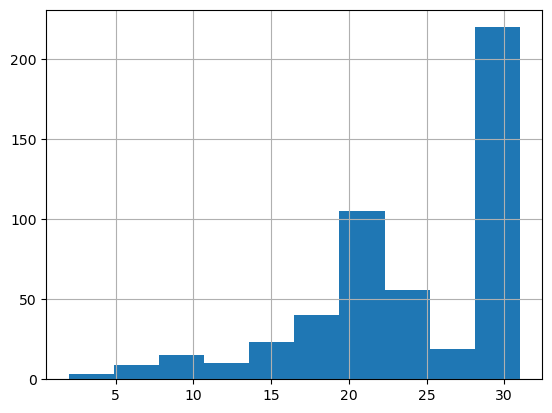

In [9]:
df['img_counts'].hist();

In [10]:
for i in range(len(lines)):
    lines[i] = lines[i].split()[0]
lines

['000001.jpg',
 '000404.jpg',
 '003415.jpg',
 '004390.jpg',
 '018062.jpg',
 '025244.jpg',
 '027771.jpg',
 '039393.jpg',
 '047978.jpg',
 '049142.jpg',
 '052385.jpg',
 '052623.jpg',
 '053184.jpg',
 '053311.jpg',
 '055834.jpg',
 '058188.jpg',
 '061431.jpg',
 '068154.jpg',
 '084705.jpg',
 '090937.jpg',
 '096324.jpg',
 '100990.jpg',
 '103728.jpg',
 '108341.jpg',
 '110376.jpg',
 '122439.jpg',
 '131731.jpg',
 '134007.jpg',
 '139106.jpg',
 '140935.jpg',
 '000002.jpg',
 '011437.jpg',
 '016335.jpg',
 '017121.jpg',
 '024291.jpg',
 '037082.jpg',
 '045318.jpg',
 '046844.jpg',
 '048360.jpg',
 '055891.jpg',
 '057357.jpg',
 '058209.jpg',
 '058400.jpg',
 '059638.jpg',
 '060925.jpg',
 '063242.jpg',
 '063616.jpg',
 '066809.jpg',
 '077346.jpg',
 '095867.jpg',
 '099877.jpg',
 '105287.jpg',
 '108661.jpg',
 '114336.jpg',
 '114625.jpg',
 '117710.jpg',
 '120280.jpg',
 '125140.jpg',
 '142601.jpg',
 '152380.jpg',
 '000003.jpg',
 '015648.jpg',
 '033840.jpg',
 '038887.jpg',
 '049972.jpg',
 '052374.jpg',
 '053297.j

In [13]:
def load_images_from_folder(folder, lines):
    images = []
    filenames = []
    for filename in tqdm(lines):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames


folder = 'celebA_500/celebA_imgs'
images, filenames = load_images_from_folder(folder, lines)

100%|███████████████████████████████████████████████████████████████████████████| 12011/12011 [00:15<00:00, 793.38it/s]


In [14]:
images

[array([[[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [216, 228, 246],
         [223, 237, 255],
         [222, 238, 254]],
 
        [[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [218, 230, 248],
         [223, 237, 255],
         [222, 238, 254]],
 
        [[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [220, 232, 250],
         [224, 238, 255],
         [223, 239, 255]],
 
        ...,
 
        [[ 26,  74, 140],
         [  1,  49, 115],
         [ 33,  78, 146],
         ...,
         [ 28,  55, 122],
         [ 30,  56, 123],
         [ 30,  56, 122]],
 
        [[ 14,  61, 129],
         [ 21,  68, 136],
         [ 51,  96, 164],
         ...,
         [ 20,  49, 118],
         [ 24,  50, 120],
         [ 24,  51, 118]],
 
        [[ 56, 103, 171],
         [ 90, 137, 205],
         [131, 176, 244],
         ...,
         [ 20,  49, 118],
  

In [38]:
def extract_features(images):
    all_features = []
    
    for img in tqdm(images):
        hist_features = []
        for i in range(3):  # Для каждого канала цвета
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_features.extend(hist.flatten())
        
        # HOG features
#         fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
#                             cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        
#         LBP features
        lbp = local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize
        
#         Статистические признаки
        mean = np.mean(img, axis=(0, 1))
        std = np.std(img, axis=(0, 1))
        max_ = np.max(img, axis=(0, 1))
        min_ = np.min(img, axis=(0, 1))
        
        # Объединение признаков
        combined_features = np.hstack([
            hist_features,
#             fd,
            lbp_hist,
            mean,
            std,
            max_,
            min_
        ])
        all_features.append(combined_features)
        
    features_df = pd.DataFrame(all_features)
    
    return features_df

X = extract_features(images)

100%|████████████████████████████████████████████████████████████████████████████| 12011/12011 [02:19<00:00, 86.20it/s]


In [39]:
X

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,800,801,802,803,804,805
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,181.045124,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,120.902716,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,106.863442,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,115.390733,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,93.602721,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,114.599191,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,165.123853,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,104.931218,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,87.155603,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0


In [40]:
targets = []
f = open('celebA_500/celebA_anno.txt')
lines2 = f.readlines()
for i in range(len(lines2)):
    targets.append(int(lines2[i].split()[1]))
targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,


In [41]:
data = pd.concat([X, pd.Series(targets, name='target')], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,target
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0,0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0,0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0,0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0,0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0,499
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0,499
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0,499
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0,499


сохраню датасет в csv, чтобы фичи не экстрактить по тыще раз

In [42]:
data.to_csv('data_catboost.csv')

In [2]:
data = pd.read_csv('data_catboost.csv').drop(['Unnamed: 0'], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,target
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0,0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0,0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0,0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0,0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0,499
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0,499
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0,499
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0,499


In [3]:
X = data.drop(["target"], axis=1)
y = data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y,
                                                  shuffle=True)

In [5]:
train_pool = Pool(data=x_train, label=y_train)
test_pool = Pool(data=x_test, label=y_test)

In [ ]:
model = CatBoostClassifier(loss_function='MultiClass',
                           random_seed=42)
model.fit(train_pool)

Learning rate set to 0.088805
0:	learn: 6.1872059	total: 42.3s	remaining: 11h 44m 11s


xD, катбуст будет учиться на cpu 12 часов, на gpu ядро умирает, попробую обучить логистическую регрессию

In [30]:
model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)

Q:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
y_pred = model_logreg.predict(X_test)
accuracy_score(y_test, y_pred)

0.026217228464419477

логрег не помогла, попробую рандомфорест, ему безразличнее переобучение

In [32]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

KeyboardInterrupt: 

короче необходимо PCA, так как размерность 12к х 800 - пиздец

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_scaled)

X_train_pca.shape

(9608, 275)

In [6]:
X_test_pca = pca.transform(scaler.transform(X_test))
X_test_pca.shape

(2403, 275)

In [7]:
train_pca_pool = Pool(data=X_train_pca, label=y_train)
test_pool = Pool(data=X_test_pca, label=y_test)

In [17]:
model_cb = CatBoostClassifier(loss_function='MultiClass',
                             random_seed=42,
                             task_type='GPU',
                             iterations=300,
                             depth=6,
                             learning_rate=0.2)
model_cb.fit(train_pca_pool)

0:	learn: 6.1471463	total: 1.24s	remaining: 6m 10s
1:	learn: 6.0958483	total: 2.45s	remaining: 6m 5s
2:	learn: 6.0567158	total: 3.67s	remaining: 6m 3s
3:	learn: 6.0067428	total: 4.9s	remaining: 6m 2s
4:	learn: 5.9484284	total: 6.15s	remaining: 6m 2s
5:	learn: 5.9065578	total: 7.5s	remaining: 6m 7s
6:	learn: 5.8491943	total: 8.81s	remaining: 6m 8s
7:	learn: 5.8026815	total: 10.1s	remaining: 6m 7s
8:	learn: 5.7601124	total: 11.3s	remaining: 6m 5s
9:	learn: 5.7206247	total: 12.6s	remaining: 6m 4s
10:	learn: 5.6837466	total: 13.8s	remaining: 6m 2s
11:	learn: 5.6477699	total: 15s	remaining: 6m 1s
12:	learn: 5.5972977	total: 16.3s	remaining: 5m 59s
13:	learn: 5.5433932	total: 17.6s	remaining: 5m 58s
14:	learn: 5.4848739	total: 18.8s	remaining: 5m 56s
15:	learn: 5.4273034	total: 20.1s	remaining: 5m 56s
16:	learn: 5.3802890	total: 21.4s	remaining: 5m 55s
17:	learn: 5.3500131	total: 22.6s	remaining: 5m 53s
18:	learn: 5.3027832	total: 23.8s	remaining: 5m 51s
19:	learn: 5.2519633	total: 25s	remai

157:	learn: 0.9515649	total: 3m 14s	remaining: 2m 55s
158:	learn: 0.9310563	total: 3m 16s	remaining: 2m 54s
159:	learn: 0.9104245	total: 3m 17s	remaining: 2m 52s
160:	learn: 0.8907486	total: 3m 18s	remaining: 2m 51s
161:	learn: 0.8756526	total: 3m 20s	remaining: 2m 50s
162:	learn: 0.8564405	total: 3m 21s	remaining: 2m 49s
163:	learn: 0.8382787	total: 3m 22s	remaining: 2m 48s
164:	learn: 0.8206863	total: 3m 24s	remaining: 2m 47s
165:	learn: 0.8050715	total: 3m 25s	remaining: 2m 45s
166:	learn: 0.7880240	total: 3m 26s	remaining: 2m 44s
167:	learn: 0.7713216	total: 3m 28s	remaining: 2m 43s
168:	learn: 0.7549566	total: 3m 29s	remaining: 2m 42s
169:	learn: 0.7399532	total: 3m 30s	remaining: 2m 41s
170:	learn: 0.7248914	total: 3m 32s	remaining: 2m 39s
171:	learn: 0.7096293	total: 3m 33s	remaining: 2m 38s
172:	learn: 0.6945834	total: 3m 34s	remaining: 2m 37s
173:	learn: 0.6810215	total: 3m 35s	remaining: 2m 36s
174:	learn: 0.6671313	total: 3m 37s	remaining: 2m 35s
175:	learn: 0.6536550	total:

In [20]:
y_pred = model_cb.predict(X_test_pca)
accuracy_score(y_test, y_pred)

0.05326674989596338